In [1]:
import torch
import numpy as np
import pandas as pd
import deepxde as dde
import seaborn as sns
import matplotlib.pyplot as plt

from utils import dt2int
from collections import namedtuple

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
# better plots
sns.set_style("whitegrid")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
# load parameters
orig_params = pd.read_csv("parameters/vpatient_params.csv")
mean_params = orig_params.mean(numeric_only=True)
est_params = ["kp2", "k1", "k2", "kp1", "ki", "ke1", "kmax", "kmin", "kabs", "kp3"]

adult_params = orig_params[orig_params.Name.str.contains("adult")].loc[:, est_params]
p_range = torch.stack([torch.from_numpy(adult_params.min().to_numpy()), torch.from_numpy(adult_params.max().to_numpy())], axis=1)
def get_param(p, p_min, p_max):
    return ((torch.tanh(p) + 1) / 2) * (p_max - p_min) + p_min

In [5]:
# clean up 
mean_params = mean_params.rename(lambda x: x.replace(" ", ""))

In [6]:
# read and preprocess data
data = pd.read_csv("results/adult#001.csv")

# destructure data
data_t = data["Time"].map(lambda d: dt2int(d, fmt="%Y-%m-%d %H:%M:%S.%f")).to_numpy()
data_BG = data["BG"].to_numpy()
data_CGM = data["CGM"].to_numpy()
data_CHO = data["CHO"].to_numpy()
data_insulin = data["insulin"].to_numpy()

# normalize time
data_t -= data_t[0]

# scale down to minutes
data_t = data_t / 60.0

# clean
data_CHO = np.nan_to_num(data_CHO, nan=data_CHO[0])
data_insulin = np.nan_to_num(data_insulin, nan=data_insulin[0])

In [7]:
# system parameters
kp2  = dde.Variable(mean_params["kp2"]) 
k1   = dde.Variable(mean_params["k1"])
k2   = dde.Variable(mean_params["k2"])
kp1  = dde.Variable(mean_params["kp1"])
ki   = dde.Variable(mean_params["ki"])
ke1  = dde.Variable(mean_params["ke1"])
kmax = dde.Variable(mean_params["kmax"])
kmin = dde.Variable(mean_params["kmin"])
kabs = dde.Variable(mean_params["kabs"])
kp3  = dde.Variable(mean_params["kp3"])
p_list_ = [kp2, k1, k2, kp1, ki, ke1, kmax, kmin, kabs, kp3]

In [8]:
# required data structures
Parameters = namedtuple("parameters", list(mean_params.keys()))
Action = namedtuple("patient_action", ['CHO', 'insulin'])

In [9]:
# convert to tensors
in_time = torch.from_numpy(data_t).float().to(device)
in_CHO = torch.from_numpy(data_CHO).float().to(device)
in_insulin = torch.from_numpy(data_insulin).float().to(device)
in_CGM = torch.from_numpy(data_CGM).float().to(device)

In [10]:
def ode(t, x):
    # instantiate derivatives
    dxdt = torch.zeros(13)

    # parameters
    params = Parameters(
        i=mean_params.i,
        x0_1=mean_params.x0_1,
        x0_2=mean_params.x0_2,
        x0_3=mean_params.x0_3,
        x0_4=mean_params.x0_4,
        x0_5=mean_params.x0_5,
        x0_6=mean_params.x0_6,
        x0_7=mean_params.x0_7,
        x0_8=mean_params.x0_8,
        x0_9=mean_params.x0_9,
        x0_10=mean_params.x0_10,
        x0_11=mean_params.x0_11,
        x0_12=mean_params.x0_12,
        x0_13=mean_params.x0_13,
        BW=mean_params.BW,
        EGPb=mean_params.EGPb,
        Gb=mean_params.Gb,
        Ib=mean_params.Ib,
        kabs=get_param(kabs, adult_params.min()["kabs"], adult_params.max()["kabs"]),
        kmax=get_param(kmax, adult_params.min()["kmax"], adult_params.max()["kmax"]),
        kmin=get_param(kmin, adult_params.min()["kmin"], adult_params.max()["kmin"]),
        b=mean_params.b,
        d=mean_params.d,
        Vg=mean_params.Vg,
        Vi=mean_params.Vi,
        Ipb=mean_params.Ipb,
        Vmx=mean_params.Vmx,
        Km0=mean_params.Km0,
        k2=get_param(k2, adult_params.min()["k2"], adult_params.max()["k2"]),
        k1=get_param(k1, adult_params.min()["k1"], adult_params.max()["k1"]),
        p2u=mean_params.p2u,
        m1=mean_params.m1,
        m5=mean_params.m5,
        CL=mean_params.CL,
        HEb=mean_params.HEb,
        m2=mean_params.m2,
        m4=mean_params.m4,
        m30=mean_params.m30,
        Ilb=mean_params.Ilb,
        ki=get_param(ki, adult_params.min()["ki"], adult_params.max()["ki"]),
        kp2=get_param(kp2, adult_params.min()["kp2"], adult_params.max()["kp2"]),
        kp3=get_param(kp3, adult_params.min()["kp3"], adult_params.max()["kp3"]),
        f=mean_params.f,
        Gpb=mean_params.Gpb,
        ke1=get_param(ke1, adult_params.min()["ke1"], adult_params.max()["ke1"]),
        ke2=mean_params.ke2,
        Fsnc=mean_params.Fsnc,
        Gtb=mean_params.Gtb,
        Vm0=mean_params.Vm0,
        Rdb=mean_params.Rdb,
        PCRb=mean_params.PCRb,
        kd=mean_params.kd,
        ksc=mean_params.ksc,
        ka1=mean_params.ka1,
        ka2=mean_params.ka2,
        dosekempt=mean_params.dosekempt,
        u2ss=mean_params.u2ss,
        isc1ss=mean_params.isc1ss,
        isc2ss=mean_params.isc2ss,
        kp1=get_param(kp1, adult_params.min()["kp1"], adult_params.max()["kp1"]),
        patient_history=mean_params.patient_history,
    )

    # get current action
    t_mask = torch.abs(in_time - t).argmin(dim=1)
    action = Action(CHO=in_CHO[t_mask], insulin=in_insulin[t_mask])

    d = action.CHO * 1000 # g -> mg
    insulin = action.insulin * 6000 / params.BW
    # basal = action.insulin[0]

    # glucose in the stomach
    qsto = x[:, 0:1] + x[:, 1:2]

    # last_foodtaken = 0
    # if t_mask > 0:
    #     last_foodtaken = action.CHO[t_mask - 1]
    last_foodtaken = torch.where(t_mask > 0, action.CHO[t_mask - 1], torch.zeros(1))
    
    Dbar = last_foodtaken * 1000 # unit: mg

    # stomach solid
    dxdt0 = -params.kmax * x[:, 0:1] + d

    aa = 5 / 2 / (1 - params.b) / Dbar
    cc = 5 / 2 / params.d / Dbar
    kgut = params.kmin + (params.kmax - params.kmin) / 2 * (
        torch.tanh(aa * (qsto - params.b * Dbar))
        - torch.tanh(cc * (qsto - params.d * Dbar))
        + 2
    )

    kgut = torch.where(Dbar > 0, kgut, params.kmax)

    # stomach liquid
    dxdt1 = params.kmax * x[:, 0:1] - x[:, 1:2] * kgut

    # intestine
    dxdt2 = kgut * x[:, 1:2] - params.kabs * x[:, 2:3]

    # Rate of appearance
    Rat = params.f * params.kabs * x[:, 2:3] / params.BW
    # Glucose Production
    EGPt = params.kp1 - params.kp2 * x[:, 3:4] - params.kp3 * x[:, 8:9]
    # Glucose Utilization
    Uiit = params.Fsnc

    # renal excretion
    Et = torch.where(x[:, 3:4] > params.ke2, params.ke1 * (x[:, 3:4] - params.ke2), 0)
    # if x[:, 3:4] > params.ke2:
    #     Et = params.ke1 * (x[:, 3:4] - params.ke2)
    # else:
    #     Et = 0

    # glucose kinetics
    # plus dextrose IV injection input u[2] if needed
    eEGPt = torch.where(EGPt < 0, 0, EGPt)
    dxdt3 = eEGPt + Rat - Uiit - Et - params.k1 * x[:, 3:4] + params.k2 * x[:, 4:5]
    dxdt3 = (x[:, 3:4] >= 0) * dxdt3

    Vmt = params.Vm0 + params.Vmx * x[:, 6:7]
    Kmt = params.Km0
    Uidt = Vmt * x[:, 4:5] / (Kmt + x[:, 4:5])
    dxdt4 = -Uidt + params.k1 * x[:, 3:4] - params.k2 * x[:, 4:5]
    dxdt4 = (x[:, 4:5] >= 0) * dxdt4

    # insulin kinetics
    dxdt5 = (
        -(params.m2 + params.m4) * x[:, 5:6]
        + params.m1 * x[:, 9:10]
        + params.ka1 * x[:, 10:11]
        + params.ka2 * x[:, 11:12]
    )  # plus insulin IV injection u[3] if needed
    It = x[:, 5:6] / params.Vi
    dxdt5 = (x[:, 5:6] >= 0) * dxdt5

    # insulin in_on glucose utilization
    dxdt6 = -params.p2u * x[:, 6:7] + params.p2u * (It - params.Ib)

    # insulin in_on production
    dxdt7 = -params.ki * (x[:, 7:8] - It)

    dxdt8 = -params.ki * (x[:, 8:9] - x[:, 7:8])

    # insulin in the liver (pmol/kg)
    dxdt9 = -(params.m1 + params.m30) * x[:, 9:10] + params.m2 * x[:, 5:6]
    dxdt9 = (x[:, 9:10] >= 0) * dxdt9

    # subcutaneous insulin kinetics
    dxdt10 = insulin - (params.ka1 + params.kd) * x[:, 10:11]
    dxdt10 = (x[:, 10:11] >= 0) * dxdt10

    dxdt11 = params.kd * x[10] - params.ka2 * x[11]
    dxdt11 = (x[:, 11:12] >= 0) * dxdt11

    # subcutaneous glucose
    dxdt12 = -params.ksc * x[12] + params.ksc * x[:, 3:4]
    dxdt12 = (x[:, 12:13] >= 0) * dxdt12

    grad0 = dde.grad.jacobian(x, t, i=0)
    grad1 = dde.grad.jacobian(x, t, i=1)
    grad2 = dde.grad.jacobian(x, t, i=2)
    grad3 = dde.grad.jacobian(x, t, i=3)
    grad4 = dde.grad.jacobian(x, t, i=4)
    grad5 = dde.grad.jacobian(x, t, i=5)
    grad6 = dde.grad.jacobian(x, t, i=6)
    grad7 = dde.grad.jacobian(x, t, i=7)
    grad8 = dde.grad.jacobian(x, t, i=8)
    grad9 = dde.grad.jacobian(x, t, i=9)
    grad10 = dde.grad.jacobian(x, t, i=10)
    grad11 = dde.grad.jacobian(x, t, i=11)
    grad12 = dde.grad.jacobian(x, t, i=12)

    return [
        grad0 - dxdt0,
        grad1 - dxdt1,
        grad2 - dxdt2,
        grad3 - dxdt3,
        grad4 - dxdt4,
        grad5 - dxdt5,
        grad6 - dxdt6,
        grad7 - dxdt7,
        grad8 - dxdt8,
        grad9 - dxdt9,
        grad10 - dxdt10,
        grad11 - dxdt11,
        grad12 - dxdt12,
    ]

In [11]:
# time domain
geom = dde.geometry.TimeDomain(data_t[0], data_t[-1])

In [12]:
# dataset
num_interior = 4094
num_boundary = 2
num_test = 1000

In [13]:
# load boundary conditions (for x) from experimental data
ds_t = data_t.reshape(-1, 1)
ds_x = data_CGM.reshape(-1, 1)

observations = dde.PointSetBC(ds_t, ds_x, component=12)

data = dde.data.PDE(geom, ode, [], num_interior, num_boundary, num_test=num_test, anchors=ds_t)

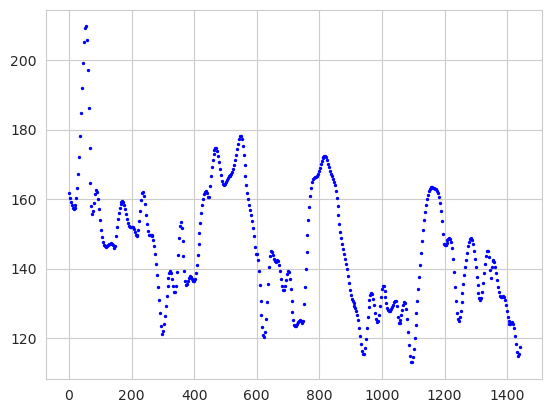

In [14]:
# visualize dataset
plt.scatter(ds_t, ds_x, s=2, color="b")
plt.show()

In [15]:
# network architecture
layers = [1] + [64] * 6 + [13]
activation = "swish"
initializer = "Glorot normal"
net = dde.nn.FNN(layers, activation, initializer)

In [16]:
# instantiate model
model = dde.Model(data, net)

In [17]:
# train with ADAM (fully supervised)
iterations = 100
model.compile("adam", lr=1e-3, loss_weights=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1e-2])
loss_history, train_state = model.train(iterations=iterations)

Compiling model...
'compile' took 0.000270 s

Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
0         [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.64e-02]    [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.65e-02]    []  
100       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]                                                                     [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]                                                                     []  

Best model at step 0:
  train loss: 1.64e-02
  test loss: 1.65e-02
  test metr